In [1]:
const SAVED_DIR = "/n/regal/pillai_lab/mrischard/saved/"
const DATA_DIR = "/n/regal/pillai_lab/mrischard/TempModel/data/"

"/n/regal/pillai_lab/mrischard/TempModel/data/"

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(8,5))
plt.rc("savefig", dpi=400.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
timezoneGMT = -5 # Georgia
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

In [4]:
using DataFrames
using TempModel
using Dates
using PDMats
using LinearAlgebra
using Printf

In [5]:
ICAO = "KWRB"

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=DATA_DIR, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=DATA_DIR)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

k_nearest = 5
isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Float64,Float64
1,722175,13860,ROBINS AFB AIRPORT,US,GA,KWRB,32.633,-83.6,89.6,1942,2015,-9.30631e6,3.84669e6
2,722170,3813,MIDDLE GEORGIA REGIONAL AIRPORT,US,GA,KMCN,32.685,-83.653,104.6,1941,2015,-9.31221e6,3.85357e6
3,722250,13829,LAWSON AAF AIRPORT,US,GA,KLSF,32.35,-85.0,70.7,1939,2015,-9.46216e6,3.80934e6
4,722190,13874,HARTSFIELD-JACKSON ATLANTA INTL AP,US,GA,KATL,33.63,-84.442,307.9,1973,2015,-9.40004e6,3.97923e6
5,723110,13873,ATHENS/BEN EPPS AIRPORT,US,GA,KAHN,33.948,-83.328,239.3,1973,2015,-9.27603e6,4.02182e6
6,722270,13864,DOBBINS AIR RESERVE BASE AIRPORT,US,GA,KMGE,33.917,-84.517,325.5,1946,2015,-9.40839e6,4.01766e6


In [6]:
# obtain the hourly temperature measurements for those stations
hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=DATA_DIR)
# mark station 1 as the test station
itest=1
# separate temperatures into train and test
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]

# emulate daily Tx/Tn measurement
hr_measure = Hour(17) # number between 0 and 24
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp]), 
    Tx=maximum(df[:temp])))
# add column to test data for TnTx (useful for plotting)
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours,ts_day,Tn,Tx
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,DateTime,Int64,Float64,Date,Float64,Float64
1,2015,1,1,0,58,0,6.0,2015-01-01T00:58:00,1,0.966667,2015-01-01,0.0,11.5
2,2015,1,1,1,58,0,5.0,2015-01-01T01:58:00,1,1.96667,2015-01-01,0.0,11.5
3,2015,1,1,2,58,0,4.0,2015-01-01T02:58:00,1,2.96667,2015-01-01,0.0,11.5
4,2015,1,1,3,58,0,4.0,2015-01-01T03:58:00,1,3.96667,2015-01-01,0.0,11.5
5,2015,1,1,4,18,0,3.0,2015-01-01T04:18:00,1,4.3,2015-01-01,0.0,11.5
6,2015,1,1,4,23,0,3.0,2015-01-01T04:23:00,1,4.38333,2015-01-01,0.0,11.5


In [7]:
module Batch
    const SAVED_DIR = "/n/regal/pillai_lab/mrischard/saved/"
    using ..TempModel
    import PyPlot; plt=PyPlot
    plt.rc("text", usetex=false)
    plt.rc("font", family="serif")
    plt.rc("font", serif="Palatino")
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    include("../src/batch_diagnostics.jl")
    include("../src/plot_diagnostics.jl")
end

┌ Warning: Deprecated syntax `parametric method syntax ImputationDiagnostic{A <: AbstractArray{Float64, 3}}(temp_impute::A, test_truth::DataFrame)` around /n/home04/mrischard/TempModel/src/batch_diagnostics.jl:273.
│ Use `ImputationDiagnostic(temp_impute::A, test_truth::DataFrame) where A <: AbstractArray{Float64, 3}` instead.
└ @ nothing /n/home04/mrischard/TempModel/src/batch_diagnostics.jl:273


Main.Batch

In [8]:
function plot_pred(GPmodel, xlim, isdSubset)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO)
    test_data = test_trimmed
    train_data = hourly_train
    stations_metadata = isdSubset
    Batch.plot_predictive(
            nearby_pred, 
            test_data, train_data, stations_metadata, 
            local_time, 
            xlim; # xlim
            imputations=1)
end

function print_diag(GPmodel)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO)
    test_data = test_trimmed
    train_data = hourly_train
    Batch.print_diagnostics(nearby_pred, test_data, train_data; ndraws=1000)
end
;

In [9]:
test_fw = Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20))
GPmodel = "matern"
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO);

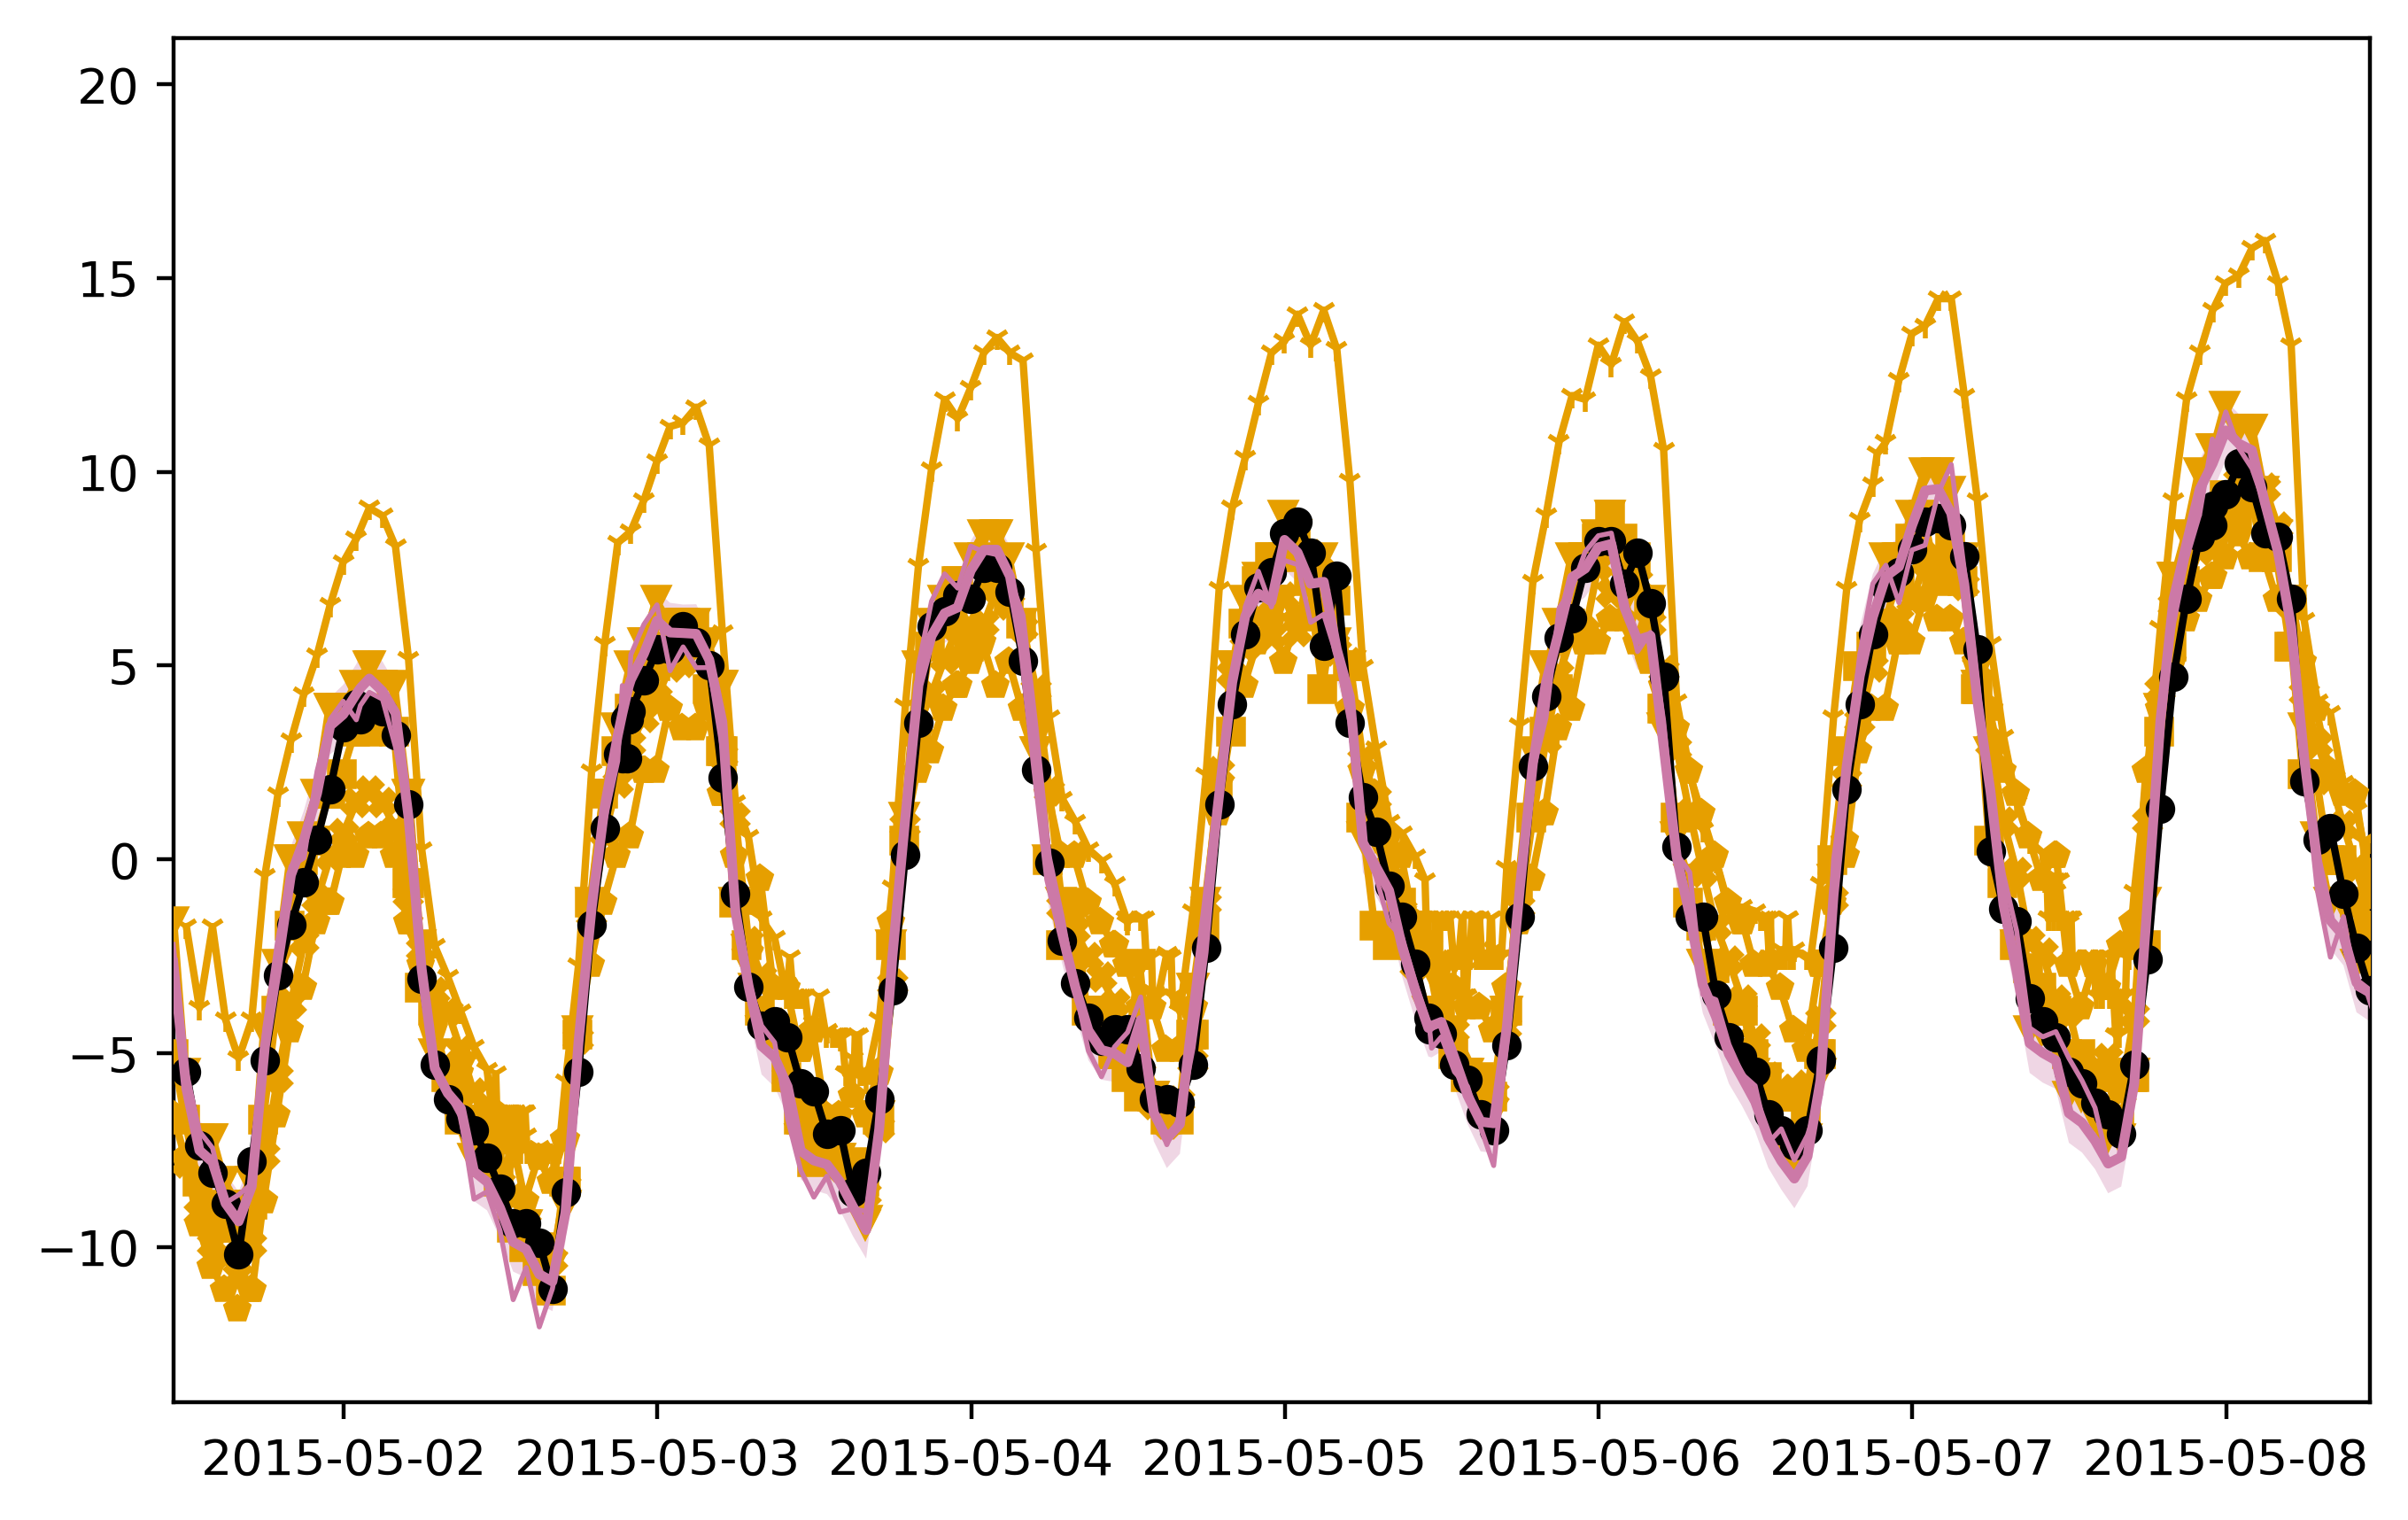

In [10]:
plot_pred("matern", 
          (DateTime(2015,5,1,6,0,0), DateTime(2015,5,8,6,0,0)),
          isd_nearest_and_test,
)
;

In [11]:
@time print_diag("matern")

var(predicted mean - simulated prediction)= 0.311
var(predicted mean - simulated prediction)= 0.391
var(predicted mean - simulated prediction)= 0.356
var(predicted mean - simulated prediction)= 0.330
var(predicted mean - simulated prediction)= 0.352
E(var(predicted mean - predictive draw))= 0.357
var(truth - predicted mean)= 0.803
  8.217946 seconds (1.78 M allocations: 615.211 MiB, 5.11% gc time)


In [12]:
function plot_imput(GPmodel)
    window_num = 40
    stan_fw = Batch.get_window(window_num)
    hr_measure = Hour(17)
    chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO)
    temp_impute = Batch.get_temperatures_reparam(chains)
    test_subsubset = Batch.get_test_fw(test_trimmed, stan_fw, hr_measure)

    Batch.plot_truth(test_subsubset, stan_fw, hr_measure, local_time; tntx=true)
    Batch.plot_imputations(test_subsubset[:ts], temp_impute, local_time)
    plt.plot(local_time.(_ts), temp_impute[500,:,1],
        color="#009F77")

    plt.legend(loc="best", fontsize="small")
    plt.title(@sprintf("Imputed %s data", titlecase(lowercase(isdSubset[itest,:NAME]))))
    plt.xlim(Date(2015,5,2), Date(2015,5,5))
end

plot_imput (generic function with 1 method)

In [13]:
plot_imput("matern")

Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
Add `using DelimitedFiles` to your imports.
  likely near /n/home04/mrischard/.julia/packages/IJulia/0cLgR/src/kernel.jl:41
in get_c

ErrorException: at row 2, column 1 : ErrorException("file entry \"# stan_version_minor = 17\" cannot be converted to Float64")

In [14]:
?CSV.read

UndefVarError: UndefVarError: CSV not defined

In [ ]:
# using CSV
# samples_path = "/n/regal/pillai_lab/mrischard/saved/stan_fit/matern/KWRB/722175_13860_KWRB_2014-12-31_to_2015-01-09/imputation_samples_1.csv"
# @time samples = CSV.read(samples_path, DataFrame; 
#     header=38,
#     skiprows=37,
#     allowmissing=:all, comment="#")
# @show size(samples)
# head(samples)

In [ ]:
using DelimitedFiles
samples_path = "/n/regal/pillai_lab/mrischard/saved/stan_fit/matern/KWRB/722175_13860_KWRB_2014-12-31_to_2015-01-09/imputation_samples_1.csv"
@time data, header = DelimitedFiles.readdlm(samples_path, ',', Float64, '\n'; 
                                      comments=true, header=true)
;

In [ ]:
1+1